# Reconstruction of systems of 1st order linear DEs by multiple time series

The method of choice is the analysis givven in [1,2] for time series' in a high dimensional space. First we explain the 1D approach by means of a Principle Component Analysis.

The basic principle is best explained in a 1D system. Given a time series $x(t)$ we are looking for a DE $\dot y(t)=f(y)$ which by integration reproduces the time series $x(t)$. To this end we minimize the mean square deviation
$$ W=\langle (\dot x(t)-f(x(t))^2\rangle $$
where
$$ \langle W(t)\rangle = \frac{1}{t_1-t_0}\int\limits_{t_0}^{t_1} W(t)dt $$
For $f(x(t))$ we make an ansatz $f(x(t))=\sum_i a_i\phi_i(x(t))$. Minimizing $W(t)$ gives the $a_i$ by $\frac{\partial W}{\partial a_i}=0$ to yield
$$ a_i=\langle \dot x\phi_j(x)\rangle D^{-1}_{ji}\mbox{ where } D_{ij}=\langle \phi_i(x)\phi_j(x)\rangle $$

For high dimensional Systems we introduce the coupling of the time series'. Given a high dimensional signal $\mathbf{x}(t)$ we want to find the corresponding equation of motion. In this case we have for the component $i$ of the vector $\mathbf{f}$
$$ f_i(\mathbf{x}) = a^{ij}x_j+a^{ijk}x_jx_k\dots$$


[1]  K. Karhunen, "Zur Spektraltheorie stochastischer Prozesse," Ann. Acad. Sci. Fenn. A1, Math. Phys. 37 (1946)

[2] C. Uhl, Analyse raumzeitlicher Daten strukturbildender Systeme, Verlag Shaker (1995)

Still to be found: M. Loeve, “Fonctions aleatoires de second ordre,” Comptes Rendus De L'Académie Des Sciences, vol. 220, (1945).

### Load the respective libraries

In [397]:
import numpy as np
import scipy.integrate as integr
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as L

### Get the data

In [2]:
numbered=np.load('Numbered.npy').item()
#
npzfile=np.load('CDR_Data.npz',allow_pickle=False)
yC=npzfile['yC']
yD=npzfile['yD']
yR=npzfile['yR']
#
# The following should be the same for all three and is for plotting
countries=yC.shape[0]
x=np.arange(yC.shape[1])

In [355]:
npzfile.files

['yC', 'yD', 'yR']

# 1D System

We define $\phi_i(x)$ and calculate $D_{ij}=\langle \phi_i(x)\phi_j(x)\rangle$ as well as its inverse $D_{ij}^{-1}$

In [395]:
# Monomials
# def phi(i,x):
#    return x**i
# Matrix D
# def CalculateDij(n):
#    Dij=np.zeros((n,n))
#    for i in np.arange(n):
#        for j in np.arange(i):
#            Dij[i,j]=np.einsum('i,i',phi(i,x),phi(j,x))/len(x)
#            Dij[j,i]=Dij[i,j]
#        Dij[i,i]=np.einsum('i,i',phi(i,x),phi(i,x))/len(x)
#    return np.linalg.inv(Dij)
# Define r.h.s. of DE
#def f(t,y):
#    return np.sum([ai[i]*phi(i,y) for i in np.arange(4)],axis=0)

In [396]:
#country='Germany'
#xoft=yC[numbered[country]]
#b=np.asarray(np.where(xoft<1))
#xoft=np.delete(xoft,np.arange(b[0,-1]+1))
#x=np.delete(x,np.arange(b[0,-1]+1))
#InvDij=CalculateDij(4)
#xdot=np.gradient(xoft,edge_order=2)
#A=[np.einsum('i,i',xdot,phi(i,xoft))/len(xoft) for i in np.arange(4)]
#ai=np.einsum('j,ji->i',A,InvDij)

In [472]:
# Define the function and the penalty function
def Func(x,*argv):
    a=[]
    for arg in argv: a=np.append(a,arg)
    #iv=np.arange(len(a))
    #return np.sum([a[i]*x**i for i in iv],axis=0)
    y=2.0*(x-x0)/(xE-x0)-1
    return L.legval(x,a)
# modified function definition with Penalization. We penalize
# 1. the difference between endpoint and initial point
# 2. the difference on the integral
def PenaltyParams(t,x):
    i0E=np.sum(((x+np.roll(x,-1))/2)[0:-2]*np.delete(t-np.roll(t,1),0)[1:])
    x0=x[0]
    xE=x[-1]
    return x0,xE,i0E
#
def FuncPen(x, *argv):
    a=[]
    for arg in argv: a=np.append(a,arg)
    #iv=np.arange(len(a))
    #integral = integr.quad( Func, t0, tE, args=argv)[0]
    integral = integr.quad(Func, t0, tE, args=argv)[0]
    penalty = abs(i0E-integral)*10000+abs(x0-Func(t0,argv))*100000+abs(xE-Func(tE,argv))*10000
    #return np.sum([a[i]*x**i for i in iv],axis=0) + penalty
    return Func(x,argv) + penalty


In [486]:
ai=np.ones(11)
# Fit to the model
country='Korea, South'
#country='Germany'
xoft=yC[numbered[country]]
#b=np.asarray(np.where(xoft<1))
#xoft=np.delete(xoft,np.arange(b[0,-1]+1))
t=np.arange(len(xoft),dtype=float)
t0=t[0]
tE=t[-1]
x0,xE,i0E=PenaltyParams(t,xoft)
# xdot=np.gradient(xoft,edge_order=2)
#
lbound=-np.inf*np.ones(len(a0))
lbound[0]=0.
ubound=np.inf*np.ones(len(a0))
bounds=(lbound,ubound)
#
popt,pcov = curve_fit(FuncPen,t,xoft,p0=ai)#,absolute_sigma=False,check_finite=True,bounds=bounds)
#

In [487]:
# Wait with that
# b=np.asarray(np.where(yC[60]<1))
# t0=np.reshape(b,(b.shape[1]))[-1]
# y0=[1.0]
# sol=solve_ivp(func,[0.,64.],y0,method='RK45')
integr.quad( Func, t0, tE, args=popt)
Func(0,popt)

-5.672227780642302

<IPython.core.display.Javascript object>


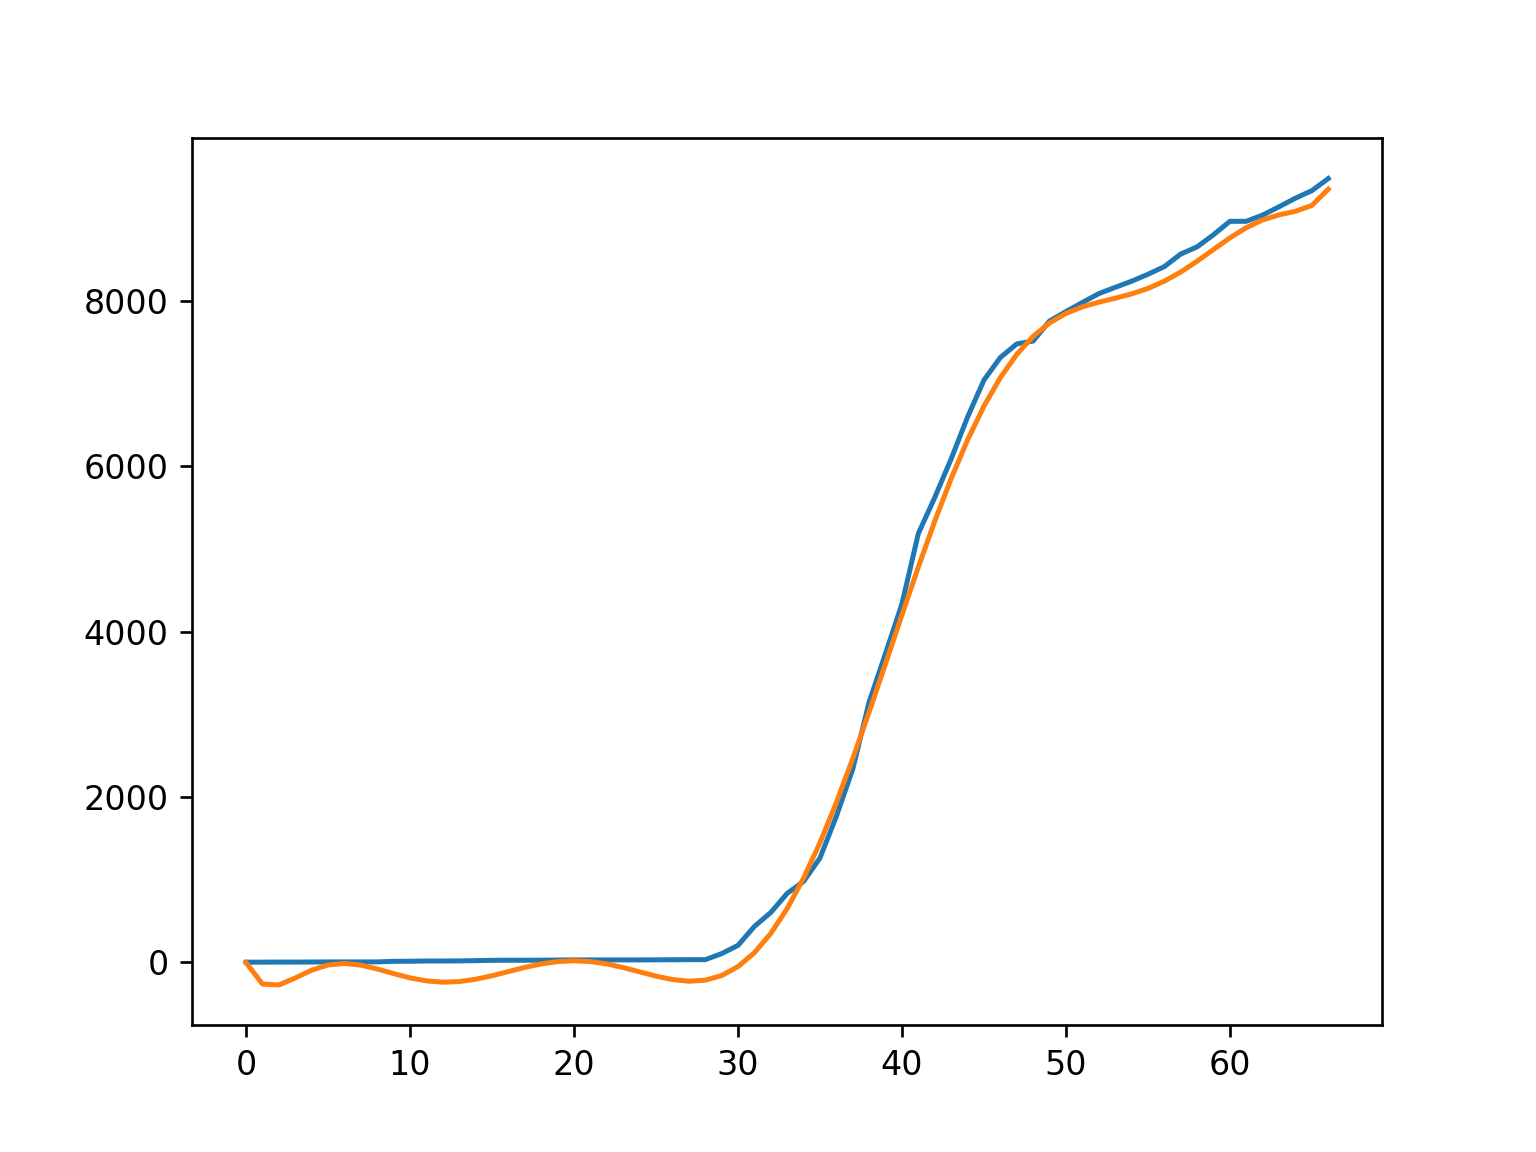

In [488]:
%matplotlib notebook
plt.plot(t,yC[numbered[country]])
plt.plot(t,Func(t,popt))

<IPython.core.display.Javascript object>


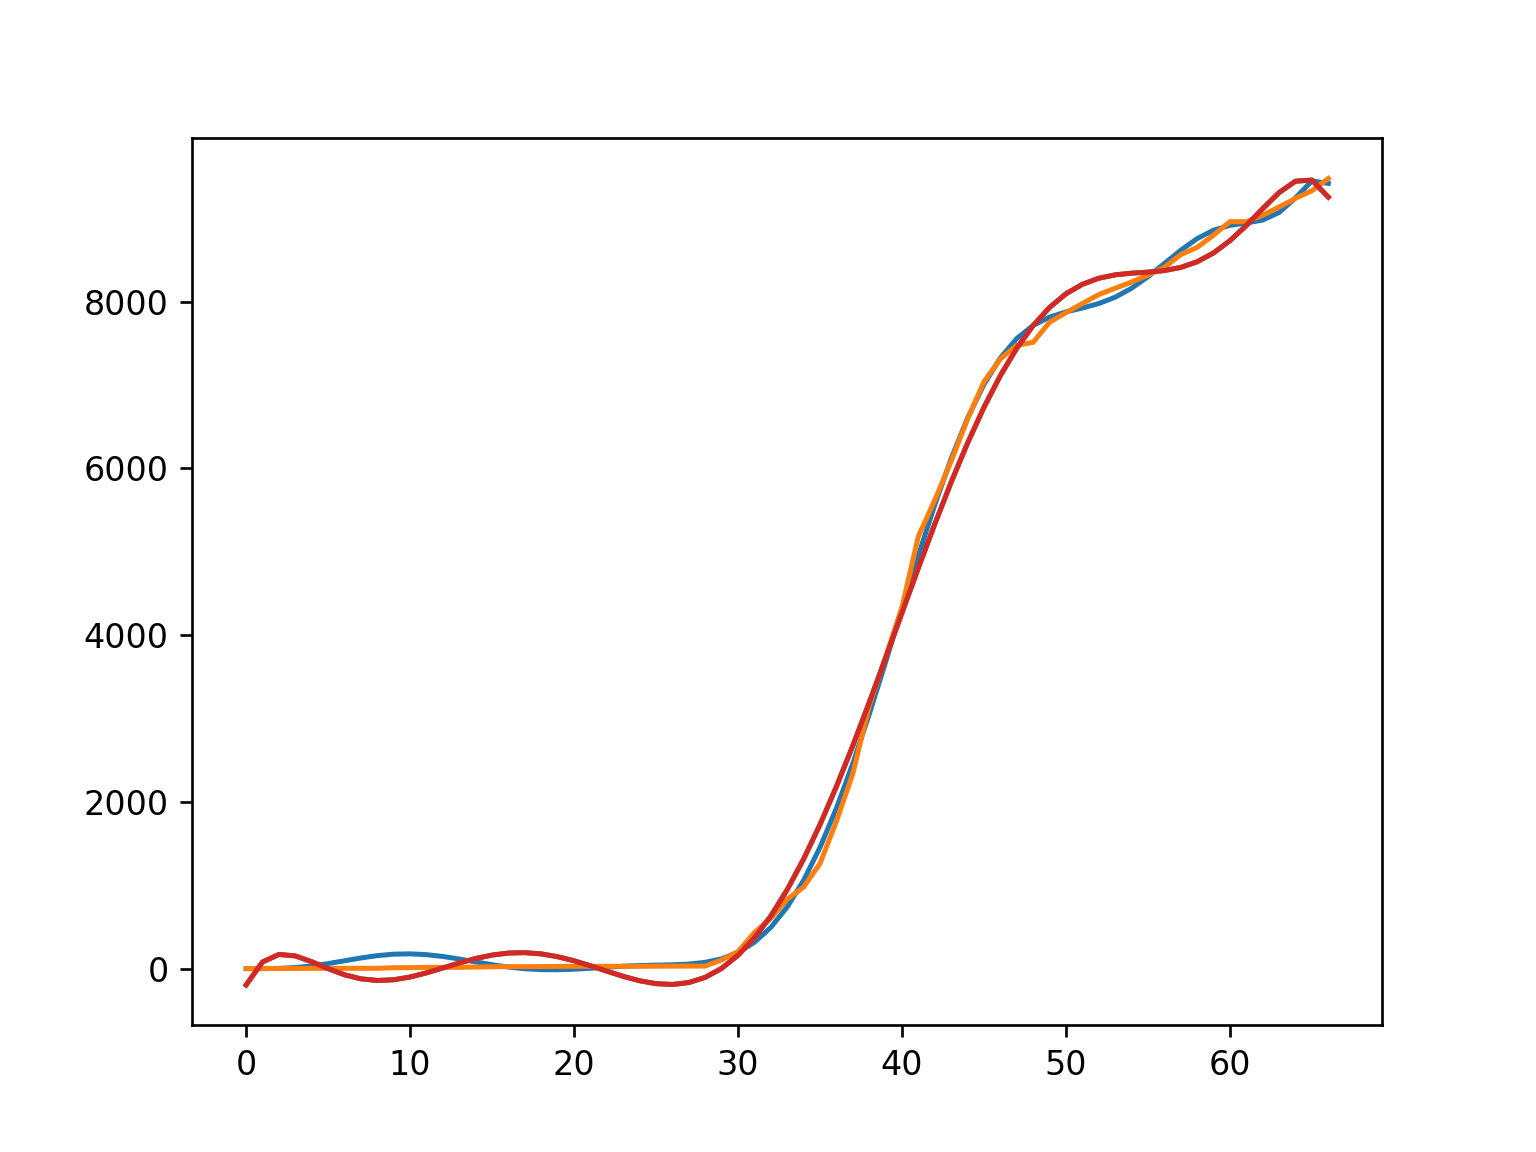

In [330]:
%matplotlib notebook
def fit(z,*argv):
    a=[]
    for arg in argv: a=np.append(a,arg)
    iv=np.arange(len(a))
    s=np.sum([a[i]*z**i for i in iv],axis=0)
    return s
#
xdata=np.arange(len(xoft),dtype=float)
ydata=xoft
a0=np.ones(15)*0.01
lbound=-np.inf*np.ones(len(a0))
lbound[0]=0.
ubound=np.inf*np.ones(len(a0))
bounds=(lbound,ubound)
popt,pcov = curve_fit(fit,xdata,ydata,p0=a0,absolute_sigma=False,check_finite=True,bounds=bounds)
#spl=UnivariateSpline(x,xoft,k=2)
#xdotspl=spl.derivative()
#xdotspl(x)
#plt.plot(x,xoft)
plt.plot(x,fit(x,popt))
plt.plot(x,ydata)

In [198]:
def fit(z,argv):
    a=np.array(argv).reshape(np.array(argv).shape[1])
    iv=np.arange(len(a))
    #a=np.asarray(argv)[0]
    return np.sum([a[i]*z**i for i in iv],axis=0)
x=np.arange(len(xoft),dtype=float)
ai=np.ones(5)*0.01

In [199]:
a=np.ones(5)*0.01
a0,a1,a2,a3,a4=a

In [200]:
a1

0.01

In [346]:
coeff=leg.legfit(x,ydata,20)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: The fit may be poorly conditioned
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


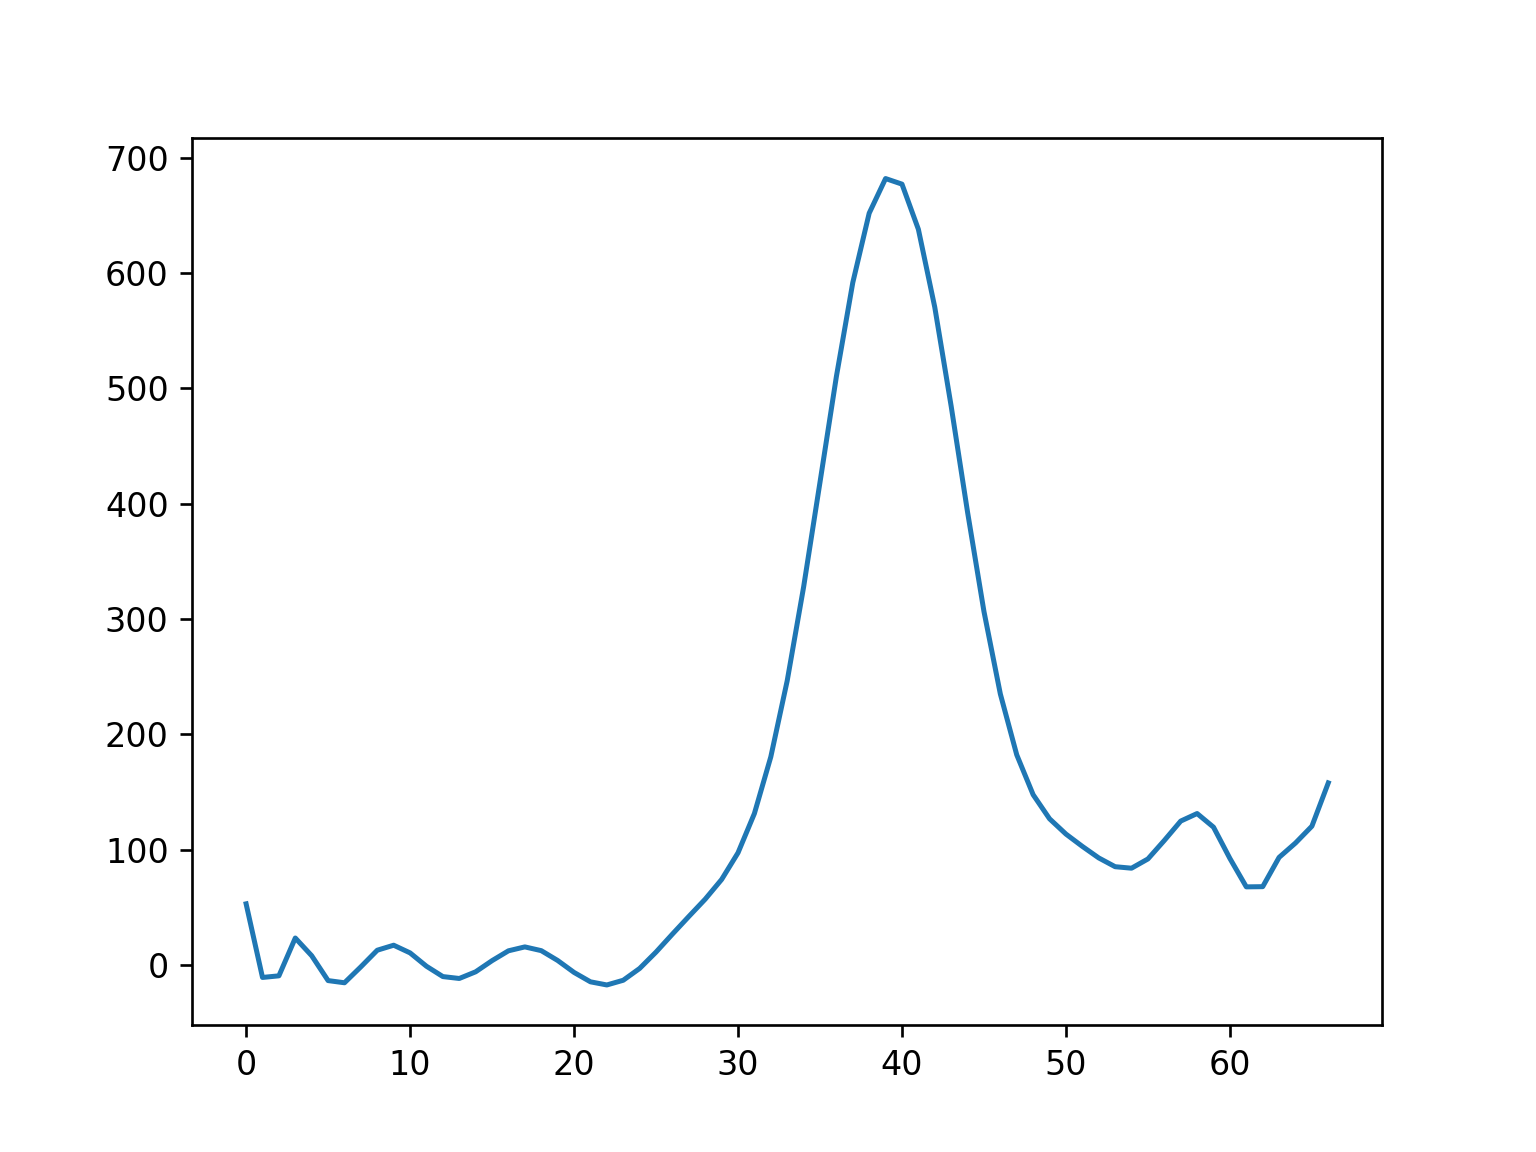

In [352]:
%matplotlib notebook
ydot=leg.legval(x,leg.legder(coeff))
y=leg.legval(x,coeff)
plt.plot(x,np.gradient(y,edge_order=2))

<IPython.core.display.Javascript object>


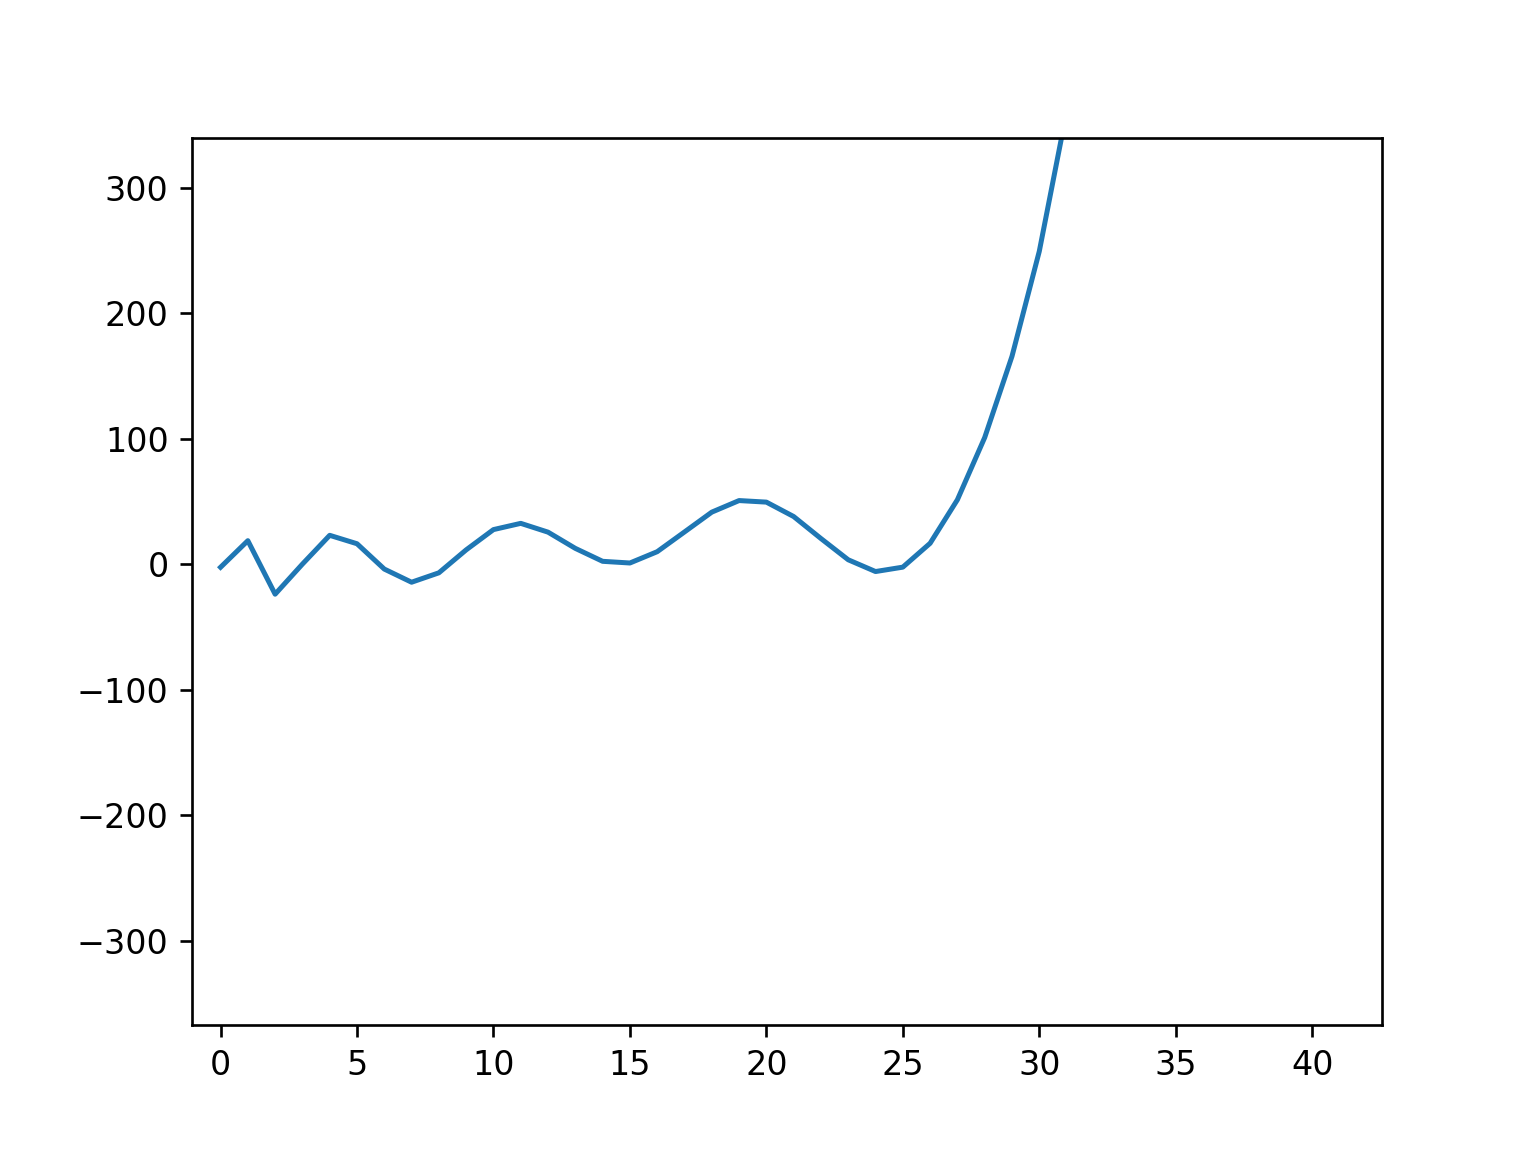

In [354]:
%matplotlib notebook
ydot=leg.legval(x,leg.legder(coeff))
y=leg.legval(x,coeff)
plt.plot(x,y)

<IPython.core.display.Javascript object>


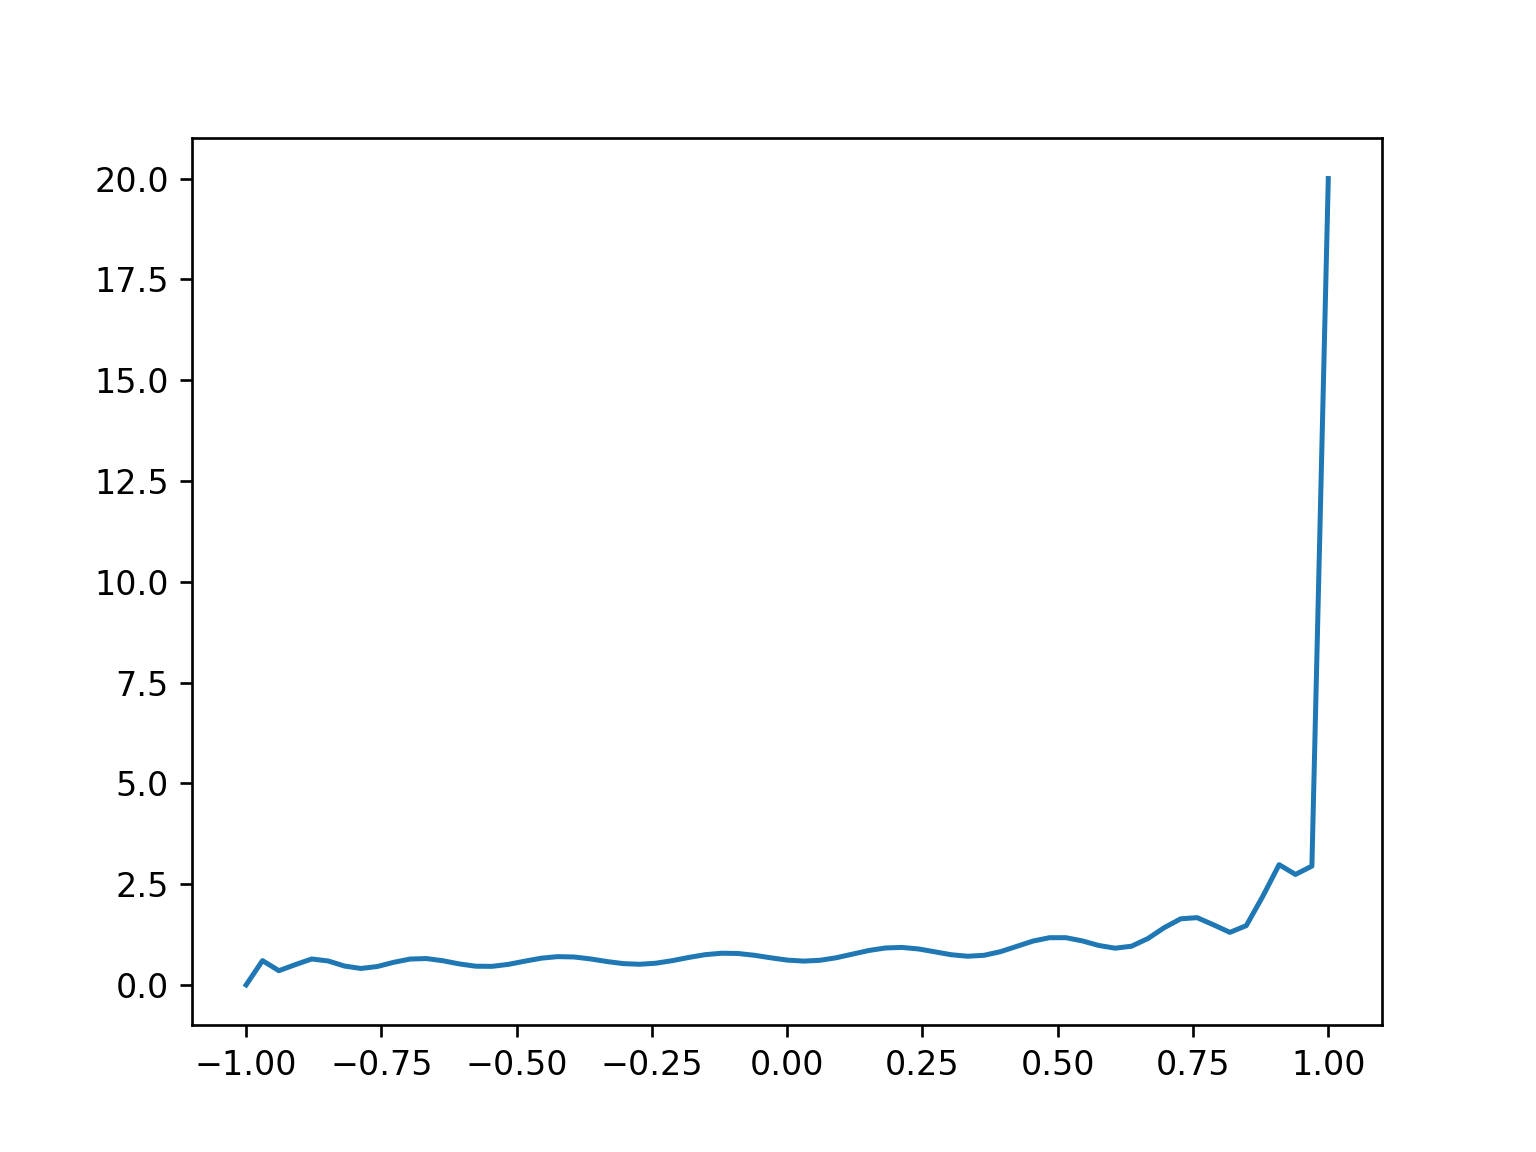

In [499]:
%matplotlib notebook
xplot=2.0*x/x[-1]-1.0
plt.plot(xplot,L.legval(xplot,c))
plt.show()

In [382]:
dx=(xplot[-1]-xplot[0])/(len(xplot))
np.sum(L.legval(xplot,[1.,0.])*dx)

2.0

In [383]:
xplot[-1]-xplot[-2]

0.030303030303030276

In [384]:
len(xplot)

67

In [390]:
dx=(/(len(x)-1)

In [391]:
dx*(len(x)-1)

0.015151515151515152

In [394]:
xplot[1]-xplot[0]

0.030303030303030276

In [410]:
np.delete(t-np.roll(t,1),0)[1:-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [405]:
xaverage=(xoft+np.roll(xoft,-1))/2

In [413]:
np.sum(((xoft+np.roll(xoft,-1))/2)[0:-2]*np.delete(t-np.roll(t,1),0)[1:])

213907.5

In [461]:
L.legval(0.,popt)

47.40415319993316

In [489]:
Func(0.,popt)

-5.672227780642302

In [498]:
c=np.ones(20)